# Теоретическая часть

## Система уравнений

В данной работе рассматривается __исскусственная__ модель, которая в предложенной статье [1] считается самой сложной из всех моделей, описанных в работе Kulikov и Weiner (2011) (https://dl.acm.org/doi/abs/10.1016/j.cam.2011.08.006). Эта модель может быть описана стохастическим дифференциальным уравнением (SDE):

$$ dx(t) = a(x(t))dt + b(t)dw(t)$$ 


Вектор $x(t)$ в данной модели состоит из трех компонент:
$$ x(t) = (x_1(t), x_2(t), x_3(t))^T ,$$

В связи с тем, что модель искусственная, компоненты вектора $x(t)$ представляют собой абстрактные переменные без какого-либо определенного физического смысла. Далее значения этих переменных будут измеряться в условных единицах измерения (у.е.и).

Модель в данной постаноке задаче переписывается следующим образом:

$$ 
d \begin{pmatrix} x_1(t) \\ x_2(t) \\ x_3(t) \end{pmatrix} = \begin{pmatrix} \lambda (x_2^2(t) - x_1(t)) + 2 x_1(t) / x_2(t) \\ x_1(t) - x_2^2(t) + 1 \\ -50(x_2(t) - 2) x_3(t) \end{pmatrix} dt + \begin{pmatrix} 0.01 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 &  0\end{pmatrix} dw(t),
$$

где $$ \lambda = 100 $$ - коэффициент жесткости дифференциального уравнения (SDE),

$$ w(t) \sim \mathcal{N}(0, I_3) $$ - шум, где $ I_3 = \begin{pmatrix} 1& 0& 0\\ 0& 1& 0\\ 0& 0& 1\end{pmatrix}. $

Стохастическое дифференциальное уравнение решается на отрезке [0, 2] со следующими начальными условиями:

$$ x(0) = x_0 \sim \mathcal{N}(\tilde x_0, \Pi_0), $$ где

$$ \tilde x_0 = \begin{pmatrix} 1 \\ 1 \\ exp(-25) \end{pmatrix}, \Pi_0 = \begin{pmatrix} 0.01 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 &  0\end{pmatrix}. $$

Также отдельно выпишем выражения для $a(x(t))$ и для $b(t)$:

$$ a(x(t)) = \begin{pmatrix} \lambda (x_2^2(t) - x_1(t)) + 2 x_1(t) / x_2(t) \\ x_1(t) - x_2^2(t) + 1 \\ -50(x_2(t) - 2) x_3(t) \end{pmatrix}, $$

$$ b(t) = B = \begin{pmatrix} 0.01 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 &  0\end{pmatrix}. $$

____Решение стохастического дифференциального уравнения задается следующим образом____:

$$ y(t_k) = y_k = x_2(t_k) + v_k $$

$$ v_k \sim \mathcal{N} (0, 0.04)$$

Для моделирования траекторий исходной системы воспользуемся схемой Эйлера-Маруямы:


$$ x_n = x_{n-1} + a(x_{n-1}) * h + B * \sqrt h * \sqrt I_3 * \mathcal{N} (0, 1) , \forall n = \overline{1,100000}$$

$$ y_k = x_2(t_{k-1}) + \mathcal{N} (0, 0.04), \forall k = \overline{1, 20}. $$

Еще раз отметим, что стохастическое дифференциальное уравнение решается на отрезке [0, 2]. Состояния динамической системы моделируется в непрерывном времени с шагом $h = 0.00002$, а наблюдения в дискретном времени с шагом $0.1$. Значения фильтров вычисляются с шагом $0.002$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats

%matplotlib inline

## Инициализация

In [13]:
N = 100_000
h = 0.00002

N_observ = 20
step_observ = 5000

In [14]:
B = np.array([[0.01, 0, 0], [0, 0, 0], [0, 0, 0]])
X_noise = np.random.normal(loc=0, scale=1, size=(3, N+1))
I = np.diag([1, 1, 1])
lambda_variable = 100

In [15]:
X_0 = np.array([[1],
                [1],
                [np.exp(-25)]])

In [16]:
X = np.zeros((3, N), dtype=float)
X = np.concatenate((X_0, X), axis=1)
y = np.zeros(N_observ+1, dtype=float)

In [17]:
X.shape

(3, 100001)

##### Функция для генерации шума состояний

In [18]:
def noise_X(B, I, h, X_noise):
    return np.dot(B, np.sqrt(I)) * np.sqrt(h) @ X_noise

#### a(x(t))

In [19]:
def get_a_t(lambda_variable, x):
    tmp_mas = np.array([
        lambda_variable*(x[1]**2 - x[0]) + 2*x[0]/x[1],
        x[0] - x[1]**2 + 1,
        -50 * (x[1] - 2) * x[2],
    ])
    return tmp_mas

In [20]:
def get_y(x):
    noise = np.random.normal(loc=0, scale=0.2, size=(1,))
    return x[1] + noise

#### Моделирование траекторий x(t)

In [21]:
for i in tqdm(range(1, N + 1)):
    X[:, i] = X[:, i-1] + h * get_a_t(lambda_variable, X[:, i-1]) + noise_X(B, I, h, X_noise)[:, i]

100%|█████████████████████████████████| 100000/100000 [00:14<00:00, 6983.40it/s]


##### Посмотрим как выглядит X

In [22]:
X

array([[1.00000000e+00, 1.00010387e+00, 1.00022489e+00, ...,
        8.99975852e+00, 8.99989823e+00, 9.00000405e+00],
       [1.00000000e+00, 1.00002000e+00, 1.00004000e+00, ...,
        2.99982860e+00, 2.99984862e+00, 2.99986863e+00],
       [1.38879439e-11, 1.39018318e-11, 1.39157334e-11, ...,
        1.37642767e-11, 1.37505148e-11, 1.37367664e-11]])

#### Моделирование наблюдений y(t)

In [23]:
for i in range(N_observ+1):
    y[i] = get_y(X[:, i * step_observ])

##### Посмотрим как выглядят наблюдения

In [24]:
y

array([0.83050102, 0.83981773, 1.37977873, 1.44810962, 1.98512902,
       1.62832251, 1.4805651 , 1.5281684 , 1.72140958, 2.26026216,
       2.05650407, 2.11030884, 2.73002297, 2.26828052, 2.74164236,
       2.52735358, 2.87452977, 2.93538936, 2.83116902, 3.00392269,
       2.85494597])

## Иллюстрации траекторий

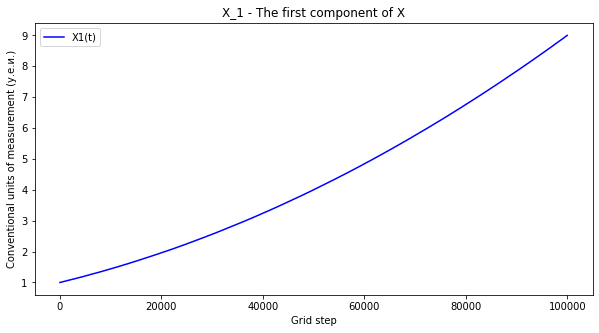

In [25]:
plt.figure(figsize=(10,5))
plt.plot(X[0, :], c="blue", label='X1(t)')
plt.title('X_1 - The first component of X')
plt.legend()
plt.xlabel("Grid step")
plt.ylabel("Conventional units of measurement (у.е.и.)")
plt.show()

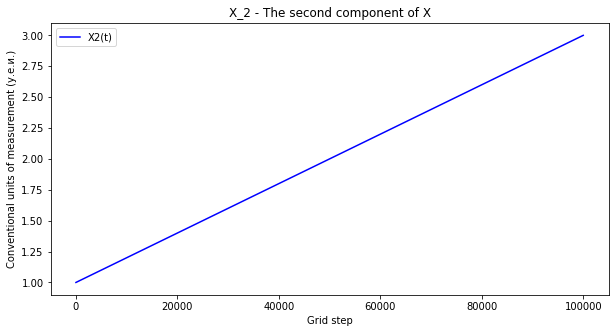

In [26]:
plt.figure(figsize=(10,5))
plt.plot(X[1,:], c="blue", label='X2(t)')
plt.title('X_2 - The second component of X')
plt.legend()
plt.xlabel("Grid step")
plt.ylabel("Conventional units of measurement (у.е.и.)")
plt.show()

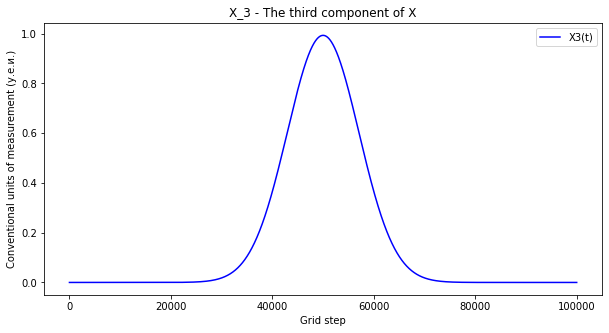

In [27]:
plt.figure(figsize=(10,5))
plt.plot(X[2,:], c="blue", label='X3(t)')
plt.title('X_3 - The third component of X')
plt.legend()
plt.xlabel("Grid step")
plt.ylabel("Conventional units of measurement (у.е.и.)")
plt.show()

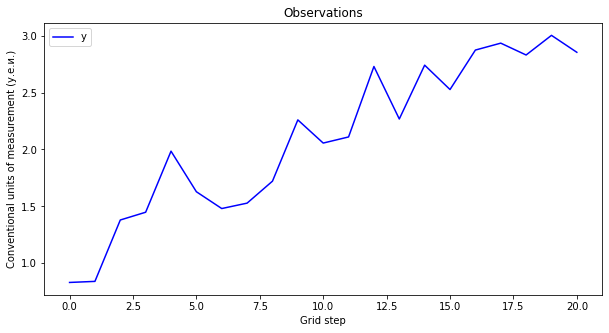

In [28]:
plt.figure(figsize=(10,5))
plt.plot(y, c="blue", label='y', lw=1.5)
plt.title('Observations')
plt.legend()
plt.xlabel("Grid step")
plt.ylabel("Conventional units of measurement (у.е.и.)")
plt.show()

## Фильтры

#### SQUARE-ROOT UKF

Описание фильтра в статьях (https://ieeexplore.ieee.org/document/7501856) и (https://www.researchgate.net/publication/3908304_The_Square-Root_Unscented_Kalman_Filter_for_State_and_Parameter-Estimation).

Начальное условие: $$\bar X_0 = E\left[X_0\right],\\s_0 = \sqrt{cov \left(X_0,X_0\right)}$$

Вычисление множества сигма-точек: $$\left\{\left(X_i(\bar X_{t-1}, s_{t-1}), w_i(\bar X_{t-1}, s_{t-1})\right)\right\}_{\overline{0,Q}}:$$
$$X_0 = m, \, w_0 = w_0\\
w_i = \displaystyle \frac{1 - w_0}{2N}, \; X_i = m + \left(\displaystyle \sqrt{\frac{N}{1 - w_0}}s\right)_i, \, i=\overline{1,N}\\
w_i = \displaystyle \frac{1 - w_0}{2N}, \; X_i = m - \left(\displaystyle \sqrt{\frac{N}{1 - w_0}}s\right)_{i-N}, \, i=\overline{N+1,2N}, \\ \text { где } \left(\sqrt{\frac{N}{1 - w_0}}s\right)_i \text{ - i-й столбец матричного квадратного корня}
$$

Шаг прогноза: $$\stackrel{\lor}{X_t} = \sum_{i=0}^Q w_i \left(\bar X_{t-1}, s_{t-1}\right)a_t\left(X_i(\bar X_{t-1}, s_{t-1})\right)\\
\stackrel{\lor}{s_t} = qr\left(\left[\sqrt{w_i}\left(a_t\left(X_i(\bar X_{t-1}, s_{t-1})\right) - \stackrel{\lor}{X_t}\right) \ \ \sqrt{b_t b_t^T}\right]\right),\ i = 1\dots 2n \\
\stackrel{\lor}{s_t} = cholupdate\left(\stackrel{\lor}{s_t},\ \left(a_t\left(X_0(\bar X_{t-1}, s_{t-1})\right) - \stackrel{\lor}{X_t}\right),\ sgn(w_0)\sqrt{w_0}\right)$$

$cholupdate$  - это малоранговая модификация матрицы. Т.е. Пусть $𝑆$ — квадратный корень матрицы $𝑃 = 𝑆𝑆^T$. Тогда малоранговая модификация матрицы
$𝑃$ есть $𝑃 ± \sqrt{𝜈}uu^T$, что, например, на языке матричных вычислений MATLAB выполняется оператором $𝑆 =
cholupdate{(𝑆, u, ±𝜈)}$.

Вычисление множества сигма-точек: $$\left\{\left(X_i(\stackrel{\lor} {X_t}, \stackrel{\lor}{s_t}), w_i(\stackrel{\lor} {X_t}, \stackrel{\lor}{s_t})\right)\right\}_{\overline{0,Q}}$$

Шаг коррекции:
$$ \stackrel{\lor}{Y_t} = \sum_{i=0}^Q w_i(\stackrel{\lor} {X_t}, \stackrel{\lor}{s_t}) A_t (X_i(\stackrel{\lor} {X_t}, \stackrel{\lor}{s_t}))\\
\bar{s_t} = qr\left(\left[\sqrt{w_i}\left(A_t\left(X_i(\stackrel{\lor} {X_t}, \stackrel{\lor}{s_t})\right) - \stackrel{\lor}{Y_t}\right) \ \ \sqrt{B_tB_t^T}\right]\right),\ i = 1\dots 2n \\
\bar{s_t} = cholupdate\left(\stackrel{\lor}{s_t},\ \left(A_t\left(X_0(\stackrel{\lor} {X_t}, \stackrel{\lor}{s_t})\right) - \stackrel{\lor}{Y_t}\right),\ sgn(w_0)\sqrt{w_0}\right) \\
\stackrel{\lor}{\mu_t} = \sum_{i=0}^Q w_i(\stackrel{\lor} {X_t}, \stackrel{\lor}{k_t})
\left(X_i(\stackrel{\lor}{X_t}, \stackrel{\lor}{k_t}) - \stackrel{\lor}{X_t}\right)\left( A_t (X_i(\stackrel{\lor} {X_t}, \stackrel{\lor}{k_t})) - \stackrel{\lor}{Y_t}\right)^T \\
\stackrel{\lor}{\kappa_t} = (\stackrel{\lor}{\mu_t} / \bar{s_t}^T) / \bar{s_t}\\
\bar X_t = \stackrel{\lor}{X_t} +  \stackrel{\lor}{\kappa_t} (Y_t - \stackrel{\lor}{Y_t})\\
\bar s_t = cholupdate\left(\stackrel{\lor}{s_t},\ \stackrel{\lor}{\kappa_t}\bar{s_t},\ -1\right)
$$

Наблюдения моделируются с шагом 0.1, а значения фильтров с шагом 0.002, поэтому когда наблюдения отсутствуют будем делать шаг прогноза без шага коррекции, т.е. считать, что: $$\bar X_t = \stackrel{\lor}{X_t}\\
\bar s_t = \stackrel{\lor}{s_t}
$$

In [265]:
class SRUKF:
    def __init__(self, noise_std=0.2, h=0.00002, step_observ=5000, N=100_000, N_observ=20, n_dim=3):
        """
        SQUARE-ROOT UNSCENTED KALMAN FILTER
        @params:
            noise_std: std of zero mean white-noise for observations
            h: step of SDE solutions
            step_observ: observation step
            N: Number of grid points
            N_observ: Number of observations
            n_dim: Number of components
        """
        self.noise_std = noise_std
        self.h = h
        self.step_observ = step_observ
        self.N = N
        self.N_observ = N_observ
        self.n_dim = n_dim
    
    
    @property
    def _step(self):
        return int(self.N / self.N_observ)

    
    def calculate_sigma_points(self, X, K):
        X_0 = X
        N = self.n_dim
        w0 = 1./N
        w = [1./N]
        w.extend([(1 - w[0]) / (2*N)] * (2*N))
        X = [X]
        mat = np.sqrt(N/(1. - w0)) * K
        X.extend(list(X_0 + mat.T) + list(X_0 - mat.T))
        return np.array(X), np.array(w)
    
    
    def get_a_t(self, x, lambda_variable):
        x0 = x[0] + self.h * (lambda_variable*(x[1]**2 - x[0]) + 2*x[0]/x[1])
        x1 = x[1] + self.h * (x[0] - x[1]**2 + 1)
        x2 = x[2] + self.h * (-50 * (x[1] - 2) * x[2])
        tmp_mas = np.array([x0, x1, x2])
        return tmp_mas.T
    

    def _matrix_cholupdate(self, X_sigma, w_sigma, a_t, b, transpose=True):
        X_pred = np.sum(a_t * w_sigma.reshape(-1, 1), axis=0)

        if transpose:
            matrix_to_concat = np.array([np.sqrt(w_sigma[i]) * (a_t[i] - X_pred).T for i in range(1, a_t.shape[0])])
        else:
            matrix_to_concat = np.array([np.sqrt(w_sigma[i]) * (a_t[i] - X_pred) for i in range(1, a_t.shape[0])])
        s_pred = np.linalg.qr(np.concatenate((matrix_to_concat, b), axis=0))[1].T
        matrix_p = s_pred @ s_pred.T + w_sigma[0] * (a_t[0] - X_pred).reshape(-1,1) @ (a_t[0] - X_pred).reshape(1,-1)
        s_pred = np.linalg.cholesky(matrix_p)
        return X_pred, s_pred
        

    def _forecast_step(self, X, w, b, lambda_variable):
        a_t = np.apply_along_axis(self.get_a_t, axis=1, arr=X, lambda_variable=lambda_variable)
        X_pred, s_pred = self._matrix_cholupdate(X, w, a_t, b, transpose=True)
        return X_pred, s_pred
    
    
    def get_y(x):
        return x[1]
    
    
    def _correction_step(self, X_pred, s_pred, y, B):
        X_sigma_hat, w_sigma_hat = self.calculate_sigma_points(X_pred, s_pred)
        A_t = get_y(X_sigma_hat.T).reshape(-1, 1)
        Y_hat, s_hat = self._matrix_cholupdate(X_sigma_hat, w_sigma_hat, A_t, B, transpose=True)        
        
        X_diff = (X_sigma_hat - X_pred.reshape(1,-1)).reshape(-1, self.n_dim, 1)
        y_diff = (get_y(X_sigma_hat.T) - Y_hat.reshape(1,-1)).reshape(-1, 1, 1)
        cov_hat = np.sum(X_diff @ y_diff * w_sigma_hat.reshape(-1, 1, 1), axis=0)
        K_hat = cov_hat @ np.linalg.pinv(s_hat.T) @  np.linalg.pinv(s_hat)
        
        tmp_p = s_pred @ s_pred.T - K_hat @ s_hat @ (K_hat @ s_hat).T
        return ((K_hat @ (y - Y_hat).reshape(-1, 1)).reshape(1, -1) + X_pred, np.linalg.cholesky(tmp_p))

    
    def initial_conditions(self, X_0, P_0):
        """Initial conditions for filtr"""
        X_0 = X_0.reshape(1, self.n_dim)
        cov_0 = np.array([[0.1, 0, 0], [0, 0, 0], [0, 0, 0]])
        cov_0 = cov_0.reshape(1, self.n_dim, self.n_dim)
        return X_0, cov_0
    
    
    def init_scale(self):
        w = np.sqrt(self.h)
        b = np.array([[0.1 * w, .0 , .0], [.0, .0, .0], [.0, .0 , .0]])
        B = np.array([[np.sqrt(self.noise_std)]])
        return b, B
    
    
    def _init_parameters(self, X_0, P_0):
        cov = np.zeros(((self.N, self.n_dim, self.n_dim)))
        UKF_X = np.zeros((self.N, self.n_dim), dtype=float)
        
        X_0, cov_0 = self.initial_conditions(X_0, P_0) # initial conditions
        
        UKF_X = np.concatenate((X_0, UKF_X), axis=0)
        cov = np.concatenate((cov_0, cov), axis=0)
        
        b, B = self.init_scale()

        step = self._step
        
        return UKF_X, cov, b, B, step 

    
    def filtration(self, X_0, P_0, y, B, I, lambda_variable):
        UKF_X, cov, b, B, step = self._init_parameters(X_0, P_0)
        # filtration
        for k in range(1, self.N + 1, 1):
            #  forecast step
            X_sigma_points, w_sigma_points = self.calculate_sigma_points(UKF_X[k-1], cov[k-1])
            new_x, new_s = self._forecast_step(X_sigma_points, w_sigma_points, b, lambda_variable)
            
            if k % step == 0:
                # correction step
                obs = np.array([y[i // step]])
                new_x, new_s = self._correction_step(new_x, new_s, obs, B)
            
            UKF_X[k] = new_x
            cov[k] = new_s
        
        return UKF_X, cov
            

In [266]:
N = 100_000
h = 0.00002

N_observ = 20
step_observ = 5000

In [267]:
B = np.array([[0.01, 0, 0], [0, 0, 0], [0, 0, 0]])
X_noise = np.random.normal(loc=0, scale=1, size=(3, N+1))
I = np.diag([1, 1, 1])
lambda_variable = 100

#### Применим фильтр UKF

In [268]:
UKF = SRUKF(N=100_000, h=0.00002, N_observ=20, step_observ=5000, n_dim=3)

In [269]:
UKF_x, cov_UKF = UKF.filtration(X_0, B, y, B, I, lambda_variable)

In [270]:
UKF_x.shape

(100001, 3)

#### Иллюстрации работы фильтра UKF

#### Для первой компоненты

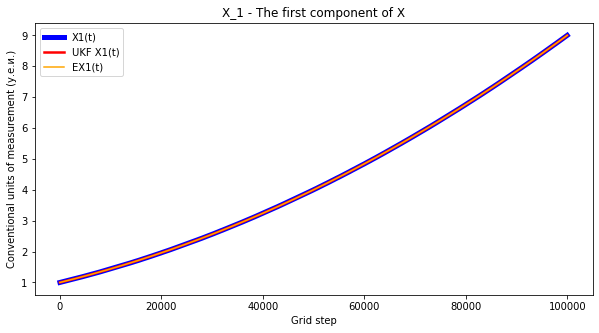

In [272]:
plt.figure(figsize=(10,5))
plt.plot(X[0, :], c="blue", label='X1(t)', linewidth = 5)
plt.plot(UKF_x[:, 0], c="red", label="UKF X1(t)", linewidth = 2.5)
plt.plot(X_trivial[0, :], c="orange", label="EX1(t)", linewidth = 1.5)
plt.title('X_1 - The first component of X')
plt.ylabel("Conventional units of measurement (у.е.и.)")
plt.legend()
plt.xlabel("Grid step")
plt.show()

#### Для второй компоненты

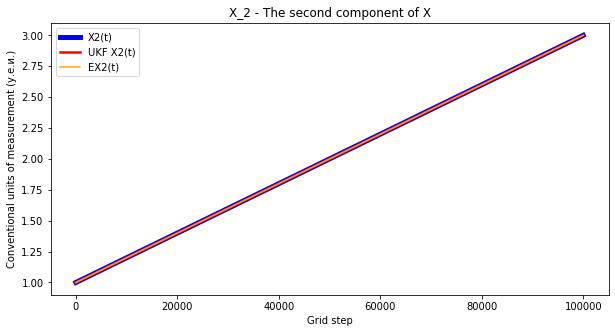

In [273]:
plt.figure(figsize=(10,5))
plt.plot(X[1, :], c="blue", label='X2(t)', linewidth = 5)
plt.plot(UKF_x[:, 1], c="red", label="UKF X2(t)", linewidth = 2.5)
plt.plot(X_trivial[1, :], c="orange", label="EX2(t)", linewidth = 1.5)
plt.title('X_2 - The second component of X')
plt.legend()
plt.ylabel("Conventional units of measurement (у.е.и.)")
plt.xlabel("Grid step")
plt.show()

#### Для третьей компоненты

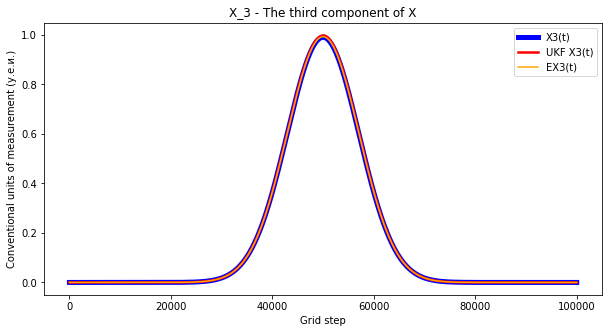

In [274]:
plt.figure(figsize=(10,5))
plt.plot(X[2, :], c="blue", label='X3(t)', linewidth = 5)
plt.plot(UKF_x[:, 2], c="red", label="UKF X3(t)", linewidth = 2.5)
plt.plot(X_trivial[2, :], c="orange", label="EX3(t)", linewidth = 1.5)
plt.title('X_3 - The third component of X')
plt.legend()
plt.ylabel("Conventional units of measurement (у.е.и.)")
plt.xlabel("Grid step")
plt.show()

#### PF(boot)

###### Возьмем $ N_{samples} = 1000 $ в качестве числа частиц, используемых в методе

$$ X_0^{(i)} \sim \pi_0(x)$$ - начальная инициализация $X_0;$

$$ w_0^{(i)} = \frac{1}{N}, i = \overline{1,N} $$ - начальная инициализация весов;

$$ \tilde X_0 = \sum_{i=1}^N w_0^{(i)} X_0^{(i)} $$

$$X_t^{(i)} \sim \pi(x| X_{t-1}^{(i)}) = |det^{-1} (b_t^{-1}(X_{t-1}^{(i)}))| p_v(b_t^{-1}(X_{t-1}^{(i)})(x-a_t(X_{t-1}^{(i)})))$$ - вычисление новой выборки;

$$\tilde w_t^{(i)}= w_{t-1}^{(i)}|det^{-1} (B_t^{-1}(X_{t}^{(i)}))| p_w(B_t^{-1}(y_t-A_t(X_{t}^{(i)})))$$ - вычисление весов;

$$ p_w(\cdot), p_v(\cdot) - \text{плотности стандартного гауссовского распределения} $$

$$ w_t^{(i)} = \frac{\tilde w_t^{(i)}}{\sum_{j=1}^N \tilde w_t^{(j)}} $$ - нормализация весов

$$ \tilde X_t = \sum_{i=1}^N w_t^{(i)} X_t^{(i)} $$ - прогноз

$$ n_{eff} = \frac{1}{\sum_{j=1}^N(w_t^{(i)})^2} $$ - перестроение выборки по значимости

Если $n_{eff} < \frac{N}{10}$, то нужно пересчитать частицы и веса $X_t^{(i)}, w_t^{(i)}:$

$$
\left\{\mathcal{X}_t^{(i)}\right\} \text{ из распределения } \left\{(X_t^{(i)},w_t^{(i)})\right\},\\
X_t^{(i)} = \mathcal{X}_t^{(i)}, \, w_t^{(i)} = \frac{1}{N}$$

In [145]:
N = 100_000
h = 0.00002

N_observ = 20
step_observ = 5000

In [275]:
class PF:
    def __init__(self, noise_std=0.2, N_samples=1000, h=0.00002, step_observ=5000, N=100_000, N_observ=20):
        """
        Particle filter
        @params:
            noise_std: std of zero mean white-noise for observations
            N_samples: Number of particles
            h: step of SDE solutions
            step_observ: observation step
            N: Number of grid points
            N_observ: Number of observations
        """
        self.noise_std = noise_std
        self.N_samples = N_samples
        self.h = h
        self.step_observ = step_observ
        self.N = N
        self.N_observ = N_observ
        self.weights = np.asarray([1/self.N_samples] * self.N_samples)
        self.noise = stats.norm(0, self.noise_std)
    
    
    @property
    def _step(self):
        return int(self.N / self.N_observ)

    
    def _weights_normalization(self):
        self.weights = self.weights / np.sum(self.weights)
    

    def _forecast_step(self, lambda_variable, B, I):

        def get_a_t(x, lambda_variable):
            tmp_mas = np.array([
                lambda_variable*(x[1]**2 - x[0]) + 2*x[0]/x[1],
                x[0] - x[1]**2 + 1,
                -50 * (x[1] - 2) * x[2],
            ])
            return tmp_mas


        def noise_f(B, I, h, X_noise):
            return np.dot(B, np.sqrt(I)) * np.sqrt(h) @ X_noise


        X_noise = np.random.normal(loc=0, scale=1, size=(3, self.N_samples))
        
        a_t = np.apply_along_axis(get_a_t, axis=1, arr=self.particles, lambda_variable=lambda_variable) * self.h
        add_weights = noise_f(B, I, self.h, X_noise)
        self.particles += a_t + add_weights.T


    def _correction_step(self, obs, pinv_B, det_B):
        
        def get_diff(particle, obs):
            return obs - particle[1]
        
        correct = np.apply_along_axis(get_diff, axis=1, arr=self.particles, obs=obs)
        correct = pinv_B * correct
        self.weights = (1/det_B) * self.noise.pdf(correct)
        self._weights_normalization()

        
    def _resampling(self):
        index_particles = np.random.choice(range(self.N_samples), self.N_samples, replace=True, p=self.weights)
        self.particles = self.particles[index_particles]
        self.weights = np.asarray([1/self.N_samples] * self.N_samples)


    def _init_scales(self):
        B = np.array([[self.noise_std]])
        pinv_B = np.linalg.pinv(B).flatten()  # здесь можно сделать flatten, т.к. 1на1
        det_B = np.linalg.det(B)
        return pinv_B, det_B


    def filtration(self, X_0, y, B, I, lambda_variable):
        self.particles = np.asarray([X_0[:, 0]] * self.N_samples)
        PF_X = np.zeros((3, self.N), dtype=float)
        PF_X = np.concatenate((X_0, PF_X), axis=1)
        pinv_B, det_B = self._init_scales()
        step = self._step
        for i in range(1, self.N + 1):
            # Forecast step
            self._forecast_step(lambda_variable, B, I)
            if i % step == 0:
                # Correction step
                obs = y[i // step]
                self._correction_step(obs, pinv_B, det_B)
            
            PF_X[:, i] = self.particles.T @ self.weights
            
            if i % step == 0:
                # Resampling condition
                N_eff = 1 / np.sum(self.weights**2)

                if N_eff < self.N_samples/10:
                    self._resampling()

        return PF_X

#### Инициализация параметров для фильтра

In [232]:
noise_std = 0.2
N_samples = 1000

N = 100_000
h = 0.00002

N_observ = 20
step_observ = 5000

##### Сгенерируем траектории и наблюдения

In [233]:
X = np.zeros((3, N), dtype=float)
X = np.concatenate((X_0, X), axis=1)
X_trivial = np.zeros((3, N), dtype=float)
X_trivial = np.concatenate((X_0, X_trivial), axis=1)
y = np.zeros(N_observ+1, dtype=float)
X_noise = np.random.normal(loc=0, scale=1, size=(3, N+1))

for i in tqdm(range(1, N + 1)):
    X[:, i] = X[:, i-1] + h * get_a_t(lambda_variable, X[:, i-1]) + noise_X(B, I, h, X_noise)[:, i]
    X_trivial[:, i] = X_trivial[:, i-1] + h * get_a_t(lambda_variable, X_trivial[:, i-1])
    
for i in range(N_observ+1):
    y[i] = get_y(X[:, i * step_observ])    

100%|█████████████████████████████████| 100000/100000 [00:13<00:00, 7686.47it/s]


#### Применим фильтр

In [151]:
PF_filtr = PF(noise_std=noise_std, N_samples=N_samples, h=h, step_observ=step_observ, N=N, N_observ=N_observ)

In [152]:
PF_X = PF_filtr.filtration(X_0, y, B, I, lambda_variable)

100%|█████████████████████████████████| 100000/100000 [01:06<00:00, 1505.45it/s]


### Иллюстрация работы фильтра PF

##### Для первой координаты

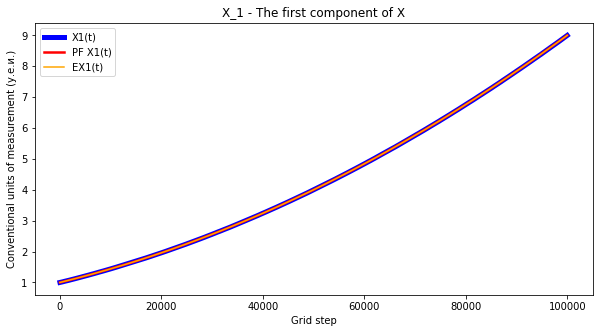

In [153]:
plt.figure(figsize=(10,5))
plt.plot(X[0, :], c="blue", label='X1(t)', linewidth = 5)
plt.plot(PF_X[0, :], c="red", label="PF X1(t)", linewidth = 2.5)
plt.plot(X_trivial[0, :], c="orange", label="EX1(t)", linewidth = 1.5)
plt.title('X_1 - The first component of X')
plt.legend()
plt.ylabel("Conventional units of measurement (у.е.и.)")
plt.xlabel("Grid step")
plt.show()

#### Для второй координаты

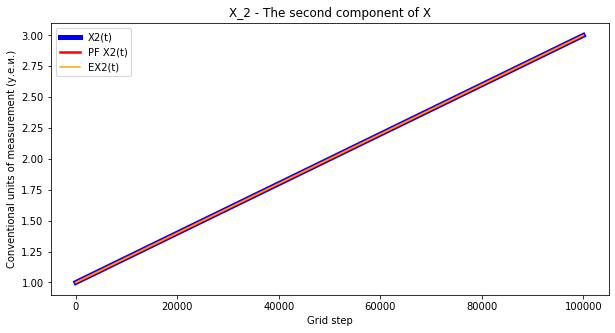

In [154]:
plt.figure(figsize=(10,5))
plt.plot(X[1, :], c="blue", label='X2(t)', linewidth = 5)
plt.plot(PF_X[1, :], c="red", label="PF X2(t)", linewidth = 2.5)
plt.plot(X_trivial[1, :], c="orange", label="EX2(t)", linewidth = 1.5)
plt.title('X_2 - The second component of X')
plt.legend()
plt.ylabel("Conventional units of measurement (у.е.и.)")
plt.xlabel("Grid step")
plt.show()

#### Для третьей координаты

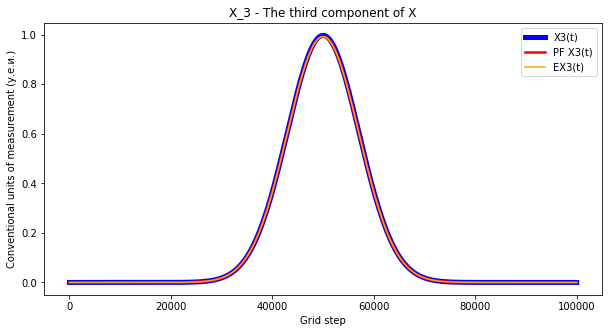

In [155]:
plt.figure(figsize=(10,5))
plt.plot(X[2, :], c="blue", label='X3(t)', linewidth = 5)
plt.plot(PF_X[2, :], c="red", label="PF X3(t)", linewidth = 2.5)
plt.plot(X_trivial[2, :], c="orange", label="EX3(t)", linewidth = 1.5)
plt.title('X_3 - The third component of X')
plt.legend()
plt.ylabel("Conventional units of measurement (у.е.и.)")
plt.xlabel("Grid step")
plt.show()

### Иллюстрации работы фильтров

In [276]:
def performing(N, N_observ, h, step_observ, noise_std, N_samples, X_0):
    
    B = np.array([[0.01, 0, 0], [0, 0, 0], [0, 0, 0]])
    X_noise = np.random.normal(loc=0, scale=1, size=(3, N+1))
    I = np.diag([1, 1, 1])
    lambda_variable = 100

    X = np.zeros((3, N), dtype=float)
    X = np.concatenate((X_0, X), axis=1)
    X_trivial = np.zeros((3, N), dtype=float)
    X_trivial = np.concatenate((X_0, X_trivial), axis=1)
    y = np.zeros(N_observ+1, dtype=float)
    X_noise = np.random.normal(loc=0, scale=1, size=(3, N+1))

    for i in tqdm(range(1, N + 1)):
        X[:, i] = X[:, i-1] + h * get_a_t(lambda_variable, X[:, i-1]) + noise_X(B, I, h, X_noise)[:, i]
        X_trivial[:, i] = X_trivial[:, i-1] + h * get_a_t(lambda_variable, X_trivial[:, i-1])

    for i in range(N_observ+1):
        y[i] = get_y(X[:, i * step_observ])  
        
    UKF = SRUKF(N=N, h=h, N_observ=N_observ, step_observ=step_observ, n_dim=3)
    PF_filtr = PF(noise_std=noise_std, N_samples=N_samples, h=h, step_observ=step_observ, N=N, N_observ=N_observ)
    
    UKF_x, cov_UKF = UKF.filtration(X_0, B, y, B, I, lambda_variable)
    PF_X = PF_filtr.filtration(X_0, y, B, I, lambda_variable)
    
    return X, X_trivial, UKF_x, cov_UKF, PF_X
    


In [277]:
def norm_illustrations(X, X_trivial, UKF_x, cov_UKF, PF_X, n_dim=3):
    for dim in range(n_dim):
        plt.figure(figsize=(10,5))
        plt.plot(X[dim, :], c="blue", label=f'X{dim+1}(t)', linewidth = 5)
        plt.plot(UKF_x[:, dim], c="red", label=f"UKF X{dim+1}(t)", linewidth = 2.5)
        plt.plot(UKF_x[:, dim] + 3 * cov_UKF[:, dim, dim], c="red", linewidth = 0.5, linestyle='--')
        plt.plot(UKF_x[:, dim] - 3 * cov_UKF[:, dim, dim], c="red", linewidth = 0.5, linestyle='--',
                label="interval +- 3 sigma")
        plt.plot(PF_X[dim, :], c="green", label=f"PF X{dim+1}(t)", linewidth = 1.5)
        plt.plot(X_trivial[dim, :], c="yellow", label=f"EX{dim+1}(t)", linewidth = 1.)
        plt.title(f'X_{dim+1}')
        plt.legend()
        plt.ylabel("Conventional units of measurement (у.е.и.)")
        plt.xlabel("Grid step")
        plt.show()
    

In [278]:
def difference_illustrations(X, X_trivial, UKF_x, cov_UKF, PF_X, n_dim=3):
    for dim in range(n_dim):
        plt.figure(figsize=(10,5))
        plt.plot(X[dim, :] - UKF_x[:, dim], c="red", label=f"UKF X{dim+1}(t)", linewidth = 2.5)
        plt.plot(3 * cov_UKF[:, dim, dim], c="red", linewidth = 0.5, linestyle='--')
        plt.plot(- 3 * cov_UKF[:, dim, dim], c="red", linewidth = 0.5, linestyle='--',
                label="interval +- 3 sigma")
        plt.plot(X[dim, :] - PF_X[dim, :], c="green", label=f"PF X{dim+1}(t)", linewidth = 1.5)
        plt.plot(X[dim, :] - X_trivial[dim, :], c="yellow", label=f"EX{dim+1}(t)", linewidth = 1.)
        plt.title(f'Ошибка оценки X_{dim+1}')
        plt.legend()
        plt.ylabel("Conventional units of measurement (у.е.и.)")
        plt.xlabel("Grid step")
        plt.show()

In [279]:
noise_std = 0.2
N_samples = 1000

N = 100_000
h = 0.00002

N_observ = 20
step_observ = 5000
X_0 = np.array([[1],
                [1],
                [np.exp(-25)]])

In [280]:
X, X_trivial, UKF_x, cov_UKF, PF_X = performing(
    N=N, N_observ=N_observ, h=h, step_observ=step_observ, noise_std=noise_std, N_samples=N_samples, X_0=X_0
)



100%|█████████████████████████████████| 100000/100000 [00:11<00:00, 9046.04it/s]


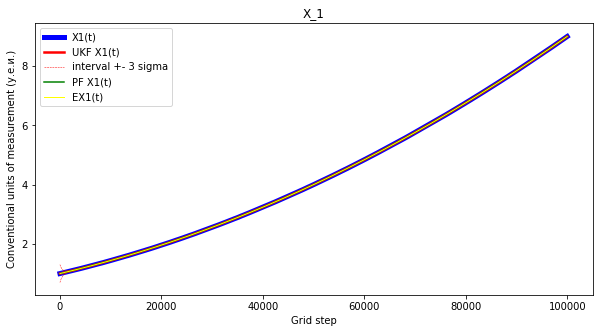

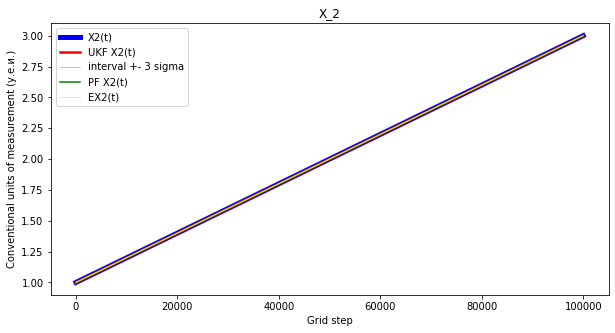

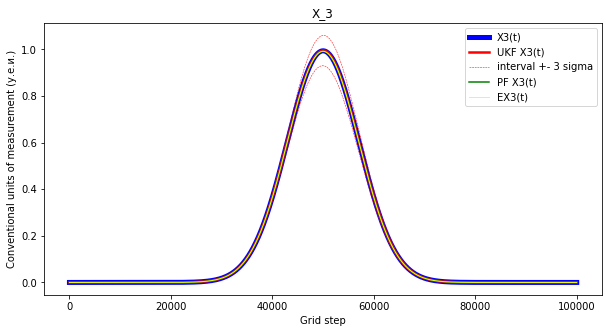

In [281]:
norm_illustrations(X, X_trivial, UKF_x, cov_UKF, PF_X)

Выше привидены иллюстрации оценивания для каждой из трех координат.

###### НО!

На этих графиках толком ничего не видно, потому что модель в этой задаче очень простая и даже тривиальная оценка дает очень хороший результат. Оценки, получаемые с помощью алгоритмов фильтрации, отличаются друг от друга не сильно, но кроме того, они не сильно отличаются и от тривиальной оценки, поэтому для более внятной иллюстрации результатов, ниже представлены иллюстрации для ошибок оценок, получаемых разными фильтрами.

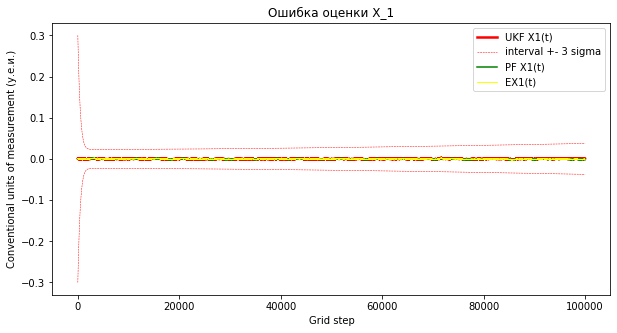

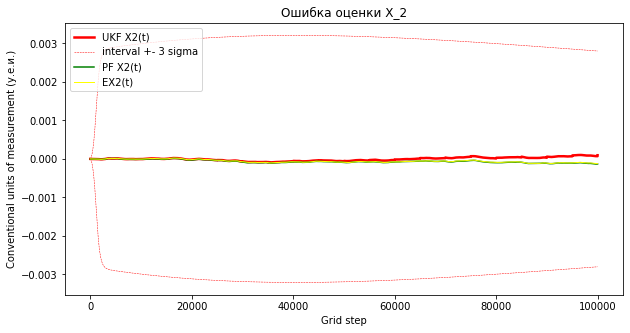

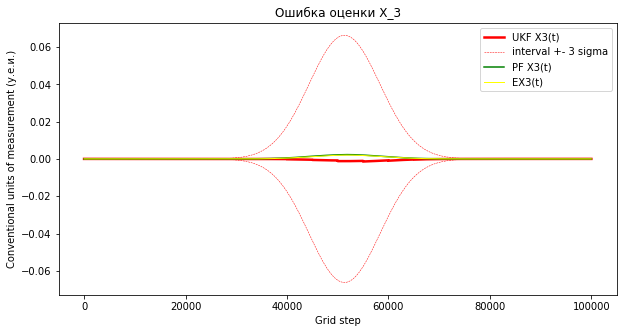

In [282]:
difference_illustrations(X, X_trivial, UKF_x, cov_UKF, PF_X)

На графиках видно, что оценка, получаемая фильтром PF очень близка к тривиальной. А ошибка оценки, получаемой с помощью UKF, отличается от ошибки тривиальной оценки (для 2 и 3 координат), и не выходит за пределы $+- 3 \sigma$. Для второй коордианты ($X_2$) похоже, что фильтр в конце предсказывает похуже, чем в начале. Для третьей координаты ($X_3$) похоже, что фильтр UKF предсказывает неплохо, и там где ошибка тривиальной оценки немного возрастает, фильтр ошибается чуточку меньше.

Оценка PF очень близка к тривиальной, поэтому рассмотрим график этих оценок более детально на некотором интервале для координаты $X_1$.

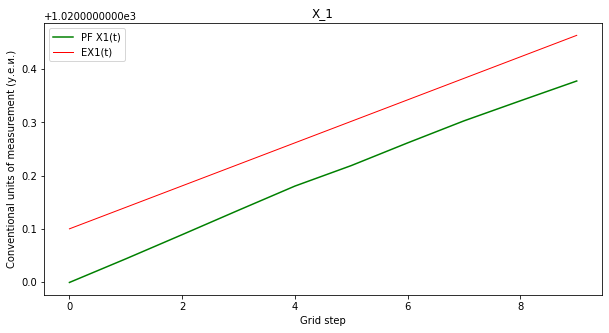

In [246]:
plt.figure(figsize=(10,5))
plt.plot(1e3 * PF_X[0, 500:510], c="green", label=f"PF X{1}(t)", linewidth = 1.5)
plt.plot(1e3 * X_trivial[0, 500:510], c="red", label=f"EX{1}(t)", linewidth = 1.)
plt.title(f'X_{1}')
plt.legend()
plt.ylabel("Conventional units of measurement (у.е.и.)")
plt.xlabel("Grid step")
plt.show()

Как видно из графика выше, оценки очень близки, но не одинаковые.

## Усреднение

#### Для усреднения возьмем 10000 траекторий и построим СКО оценок

In [283]:
def parralel_computation(N_AVG):
    X_std = []
    X_UKF_std = []
    X_PF_std = []
    single_X = []
    
    noise_std = 0.2
    N_samples = 1000

    N = 100_000
    h = 0.00002

    N_observ = 20
    step_observ = 5000
    
    PF_filtr = PF(noise_std=noise_std, N_samples=N_samples, h=h, step_observ=step_observ, N=N, N_observ=N_observ)
    UKF = SRUKF(N=N, h=h, N_observ=N_observ, step_observ=step_observ, n_dim=3)
    
    for _ in tqdm(range(N_AVG)):
        X = np.zeros((3, N), dtype=float)
        X = np.concatenate((X_0, X), axis=1)
        X_trivial = np.zeros((3, N), dtype=float)
        X_trivial = np.concatenate((X_0, X_trivial), axis=1)
        y = np.zeros(N_observ+1, dtype=float)
        X_noise = np.random.normal(loc=0, scale=1, size=(3, N+1))
        for i in range(1, N + 1):
            X[:, i] = X[:, i-1] + h * get_a_t(lambda_variable, X[:, i-1]) + noise_X(B, I, h, X_noise)[:, i]
            X_trivial[:, i] = X_trivial[:, i-1] + h * get_a_t(lambda_variable, X_trivial[:, i-1])

        for i in range(N_observ+1):
            y[i] = get_y(X[:, i * step_observ])    

        UKF_x, cov_UKF = UKF.filtration(X_0, B, y, B, I, lambda_variable)
        PF_X = PF_filtr.filtration(X_0, y, B, I, lambda_variable)

        X_std.append(X - X_trivial)
        single_X.append(X)
        X_PF_std.append(X - PF_X)
        UKF_x = UKF_x.T
        X_UKF_std.append(X - UKF_x)
    
    single_X = np.asarray(single_X)
    X_std = np.asarray(X_std)
    X_PF_std = np.asarray(X_PF_std)
    X_UKF_std = np.asarray(X_UKF_std)
    
    rnd = np.random.randint(0, 10, size=10, dtype=int).tolist()
    rnd = [str(i) for i in rnd]
    slugify = "".join(rnd)

    with open(f"X_{slugify}.npy", 'wb') as f:
        np.save(f, single_X)
        
    with open(f"X_std_{slugify}.npy", 'wb') as f:
        np.save(f, X_std)
        
    with open(f"X_PF_std_{slugify}.npy", 'wb') as f:
        np.save(f, X_PF_std)
    
    with open(f"X_UKF_std_{slugify}.npy", 'wb') as f:
        np.save(f, X_UKF_std)
    


In [296]:
from joblib import Parallel, delayed
r = Parallel(n_jobs=50)(delayed(parralel_computation)(100) for i in range(50))

100%|██████████| 100/100 [4:05:07<00:00, 147.07s/it] 

In [305]:
from joblib import Parallel, delayed
r = Parallel(n_jobs=50)(delayed(parralel_computation)(100) for i in range(50))

100%|██████████| 100/100 [4:02:27<00:00, 145.48s/it] 



In [173]:
numbers = ("16446", "41838", "43279", "68150", "83264")

In [309]:
big_numbers = ("9969283117", "9536450341", "1690658281", "0828051454", "0361308732", "9969283117", "9536450341", "1690658281", "0828051454", "0361308732",
              "4002024424", "5603009085", "8666371443", "8911281298", "9702103641")

In [307]:
def reading_and_concating(numbers):
    X_std, X_PF_std, X_UKF_std = None, None, None
    
    for num in tqdm(numbers):
        with open(f"X_PF_std_{num}.npy", 'rb') as f:
            X_PF_std_tmp = np.load(f)
        with open(f"X_UKF_std_{num}.npy", 'rb') as f:
            X_UKF_std_tmp = np.load(f)
        with open(f"X_std_{num}.npy", 'rb') as f:
            X_std_tmp = np.load(f)
        
        if X_std is None:
            X_std = X_std_tmp
            X_PF_std = X_PF_std_tmp
            X_UKF_std = X_UKF_std_tmp
        else:
            X_std = np.concatenate((X_std, X_std_tmp), axis=0)
            X_PF_std = np.concatenate((X_PF_std, X_PF_std_tmp), axis=0)
            X_UKF_std = np.concatenate((X_UKF_std, X_UKF_std_tmp), axis=0)
    
    return X_std, X_PF_std, X_UKF_std

In [310]:
X_std, X_PF_std, X_UKF_std = reading_and_concating(big_numbers)

100%|███████████████████████████████████████████| 15/15 [03:44<00:00, 14.97s/it]


##### Было сгенерировано 10000 траекторий

In [321]:
len(X_std)

10000

In [311]:
std_x = np.std(X_std, axis=0)
std_PF_x = np.std(X_PF_std, axis=0)
std_UKF_x = np.std(X_UKF_std, axis=0)

## Графики СКО ошибки оценки

#### Для первой координаты

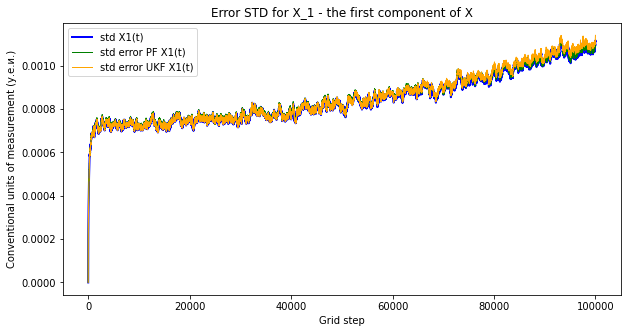

In [312]:
plt.figure(figsize=(10,5))
plt.plot(std_x[0, :], c="blue", label='std X1(t)', linewidth=2)
plt.plot(std_PF_x[0, :], c="green", label='std error PF X1(t)', linewidth=1)
plt.plot(std_UKF_x[0, :], c="orange", label='std error UKF X1(t)', linewidth=1)
plt.title('Error STD for X_1 - the first component of X')
plt.legend()
plt.ylabel("Conventional units of measurement (у.е.и.)")
plt.xlabel("Grid step")
plt.show()

#### Для второй координаты

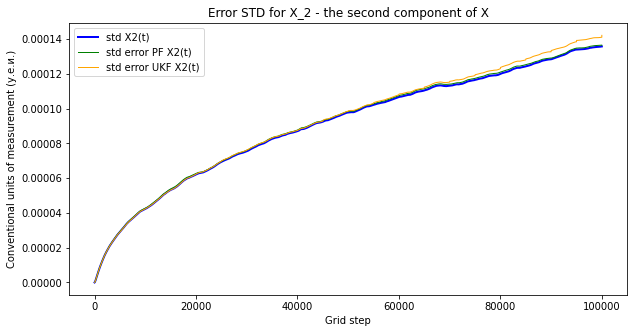

In [313]:
plt.figure(figsize=(10,5))
plt.plot(std_x[1, :], c="blue", label='std X2(t)', linewidth=2)
plt.plot(std_PF_x[1, :], c="green", label='std error PF X2(t)', linewidth=1)
plt.plot(std_UKF_x[1, :], c="orange", label='std error UKF X2(t)', linewidth=1)
plt.title('Error STD for X_2 - the second component of X')
plt.legend()
plt.ylabel("Conventional units of measurement (у.е.и.)")
plt.xlabel("Grid step")
plt.show()

#### Для третьей координаты

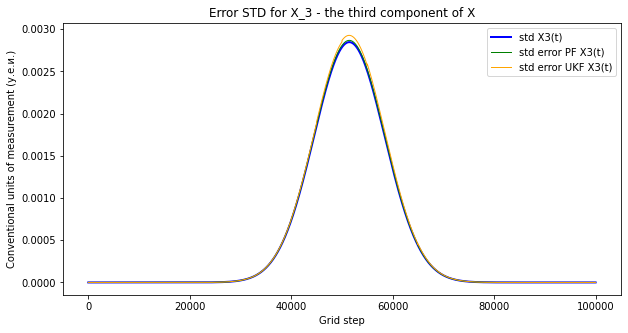

In [314]:
plt.figure(figsize=(10,5))
plt.plot(std_x[2, :], c="blue", label='std X3(t)', linewidth=2)
plt.plot(std_PF_x[2, :], c="green", label='std error PF X3(t)', linewidth=1)
plt.plot(std_UKF_x[2, :], c="orange", label='std error UKF X3(t)', linewidth=1)
plt.title('Error STD for X_3 - the third component of X')
plt.legend()
plt.ylabel("Conventional units of measurement (у.е.и.)")
plt.xlabel("Grid step")
plt.show()

Сначала СКО оценки, получаемой с помощью фильтра UKF, примерно такое же, как СКО тривиальной оценки, но к концу оценка UKF немного ухудшается.

Опять же, ошибки оценивания фильтров PF близки к ошибкам тривиальной оценки, поэтому снова рассмотрим ошибки PF более детально на некотором интервале, на примере координаты $X_1$.

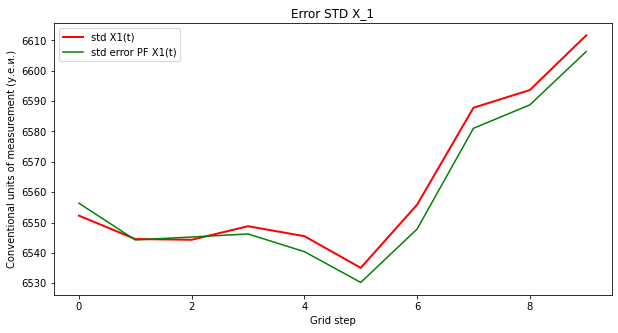

In [180]:
plt.figure(figsize=(10,5))
plt.plot(1e7 * std_x[0, 500:510], c="red", label='std X1(t)', linewidth=2)
plt.plot(1e7 * std_PF_x[0, 500:510], c="green", label='std error PF X1(t)', linewidth=1.5)
plt.title('Error STD X_1')
plt.legend()
plt.ylabel("Conventional units of measurement (у.е.и.)")
plt.xlabel("Grid step")
plt.show()

График выше иллюстрирует, что СКО для PF отличается от СКО тривиальной оценки и немного меньше СКО тривиальной оценки.

## Выводы

1. В данной модели тривиальная оценка слишком хорошая из-за того, что шума в динамике очень мало, поэтому сравнить результаты применения фильтров довольно сложно.

2. Для фильтра PF результат его оценки практически в точности совпадает с тривиальной оценкой, - это видно и на графиках СКО.

3. Для фильтра UKF точность предсказания судя по графикам высокая, но судя по графикам ошибок и графикам СКО, в конце точность предсказания немного ухудшается. Однако ошибка оценки, получаемой с помощью фильтра UKF, не выходит за пределы интервала $+- 3\sigma.$

4. Модель в данной задаче довольно странная, потому что в качестве наблюдений выступает вторая координата с добавлением относительно большого шума, в то время как шум состояний сильно меньше, возможно поэтому на шаге коррекции алгоритмы фильтрации не так хорошо оценивают состояния системы.